In [8]:
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
eps = np.finfo("float").eps

plt.style.use(["science", "ieee"])
out_path = osp.join("../outputs/figures")
metric_res_dicts_path = osp.join(out_path, "metric_res_dicts.npy")


In [9]:
metric_res_dicts= np.load(metric_res_dicts_path,allow_pickle=True).item()

In [10]:
datasets = ['Pinterest','MovieLens', 'Clothing', 'Toys']

# Plot performance

mAP


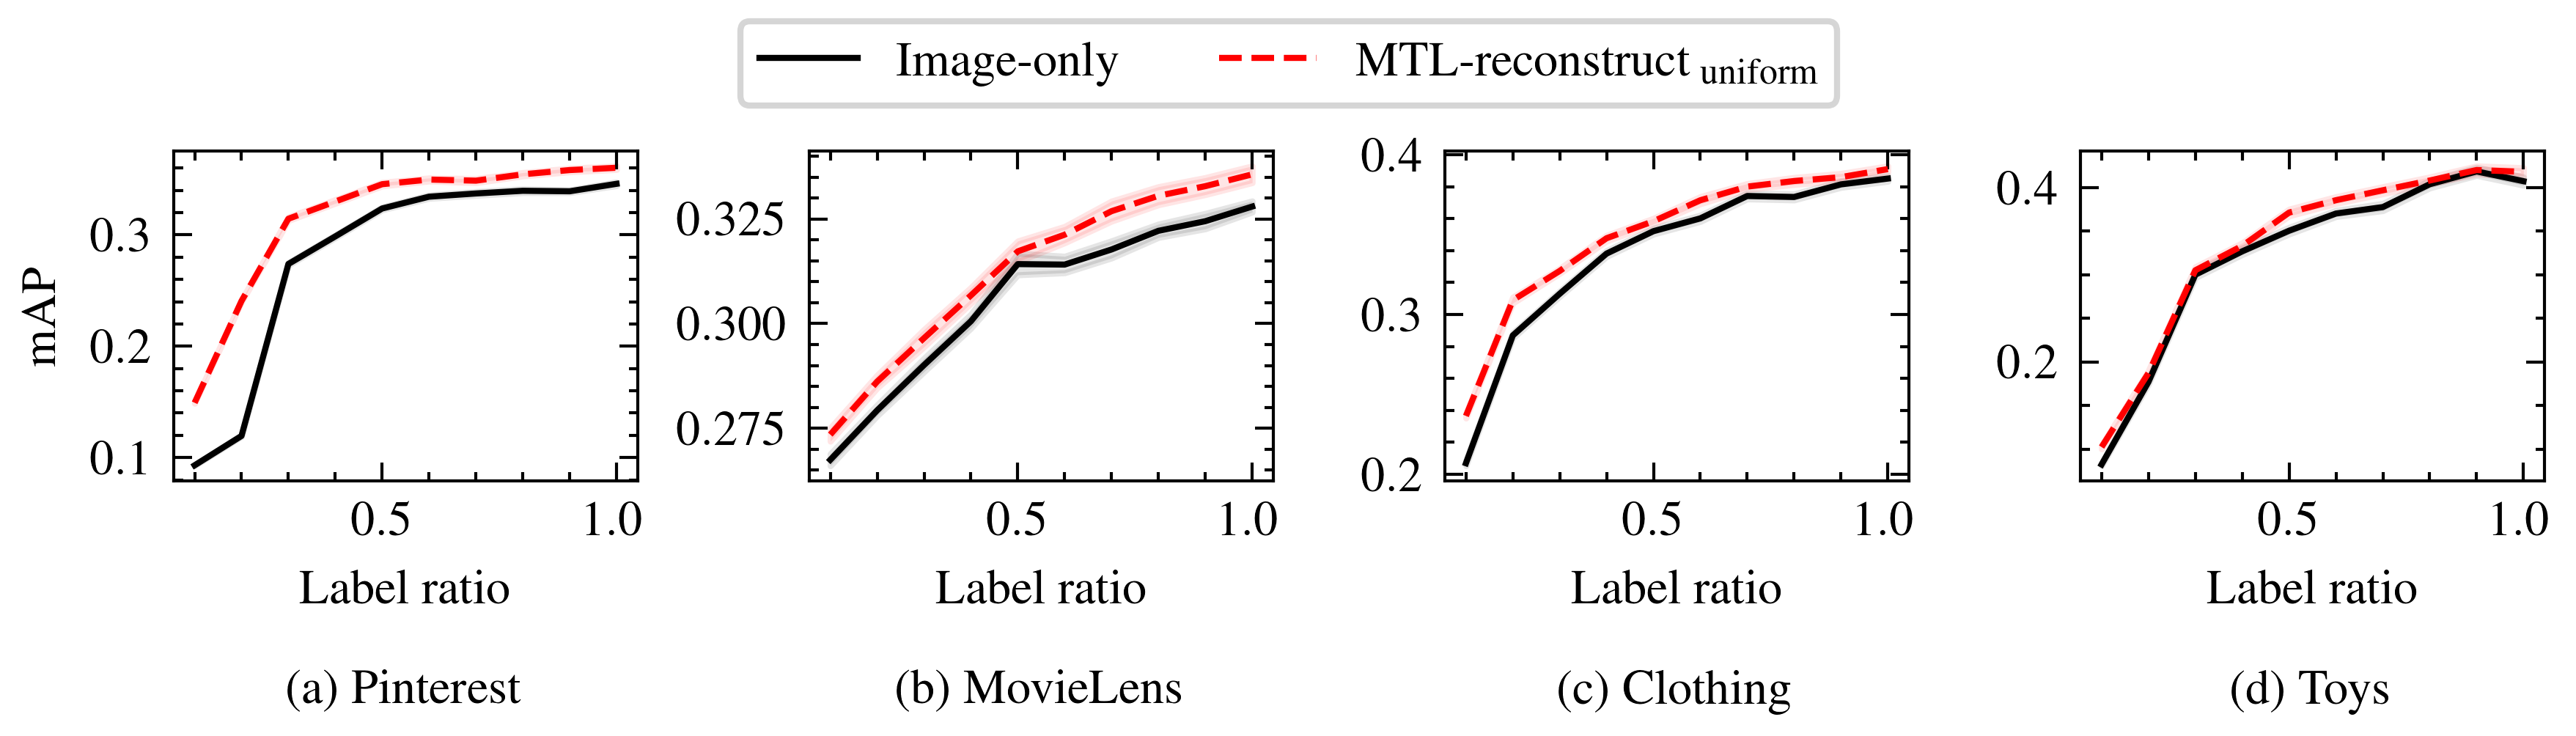

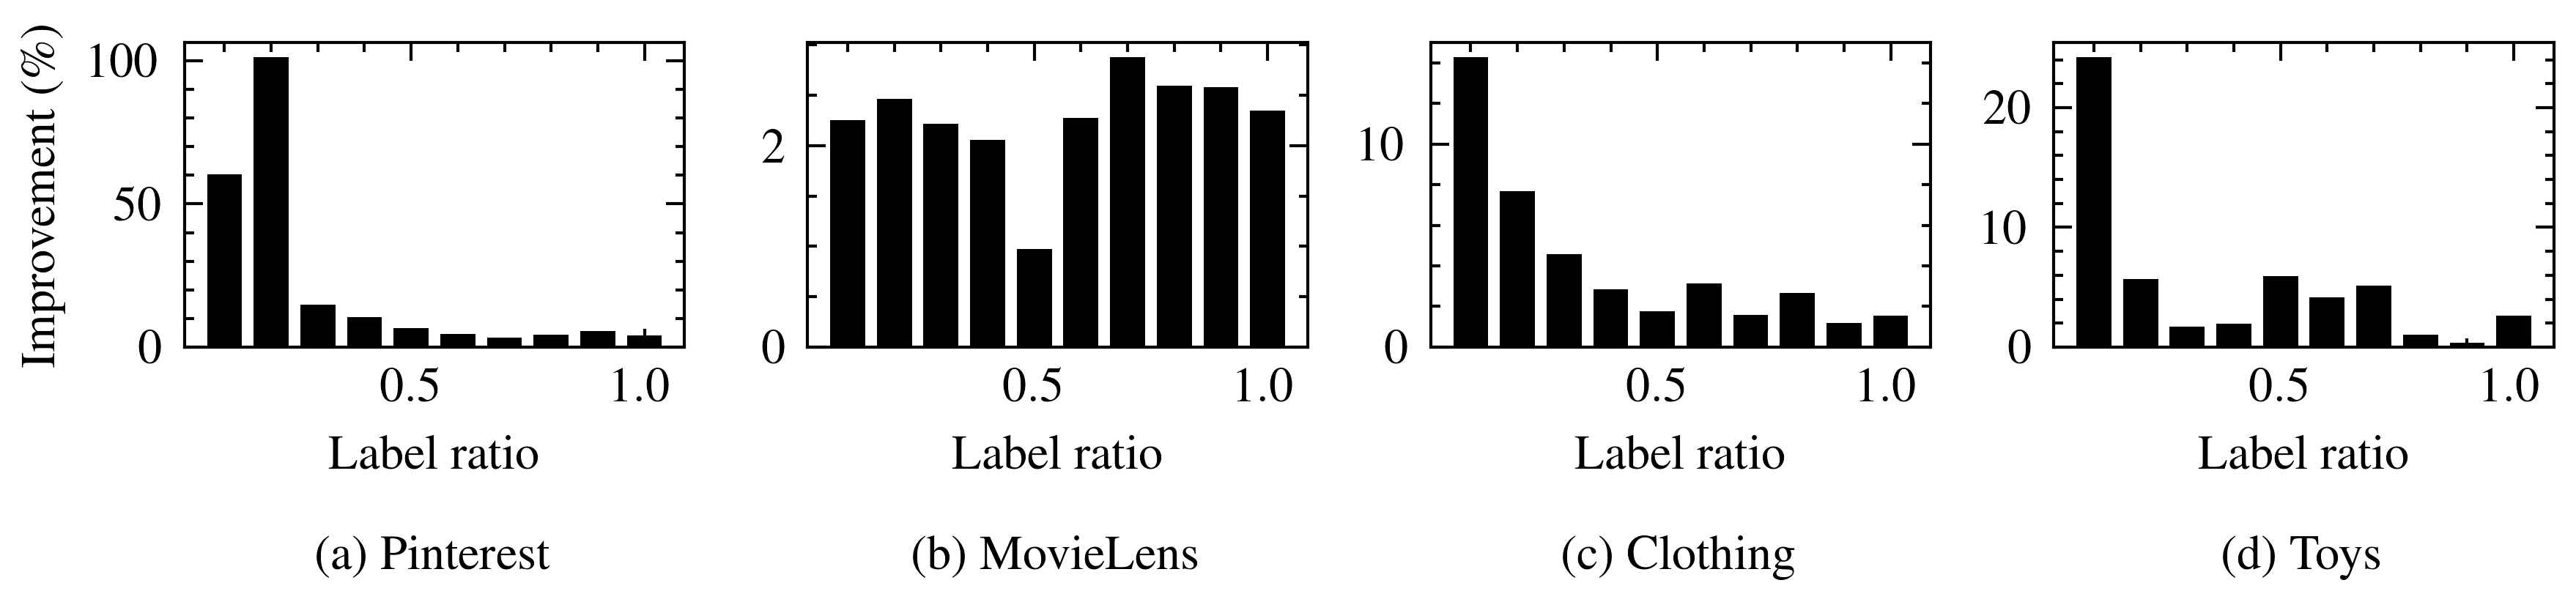

In [11]:
for k, (metric_name, single_metric_res_dict) in enumerate(metric_res_dicts.items()):
    print(metric_name)
    fig, axs = plt.subplots(1, 4, figsize=(6, 1.75))

    for row, dataset_name in enumerate(datasets): 
        df = single_metric_res_dict[dataset_name]
        ax = axs[row]

        ax.plot(df['label_ratio'], df["no_cf"], label="Image-only")
        ax.plot(df['label_ratio'], df["with_cf"], label=r"$\text{MTL-reconstruct}_\text{\ uniform}$")

        for i, key in enumerate(["no_cf", "with_cf"]):
            ax.fill_between(
                df['label_ratio'],
                df[key] - df[key + "_ci"],
                df[key] + df[key + "_ci"],
                color=f"C{i}",
                alpha=0.1,
            )

        ax.set_xlabel("Label ratio \n\n ({}) {}".format(chr(row + 97), dataset_name))
    
    axs[0].set_ylabel(metric_name.replace('_', ' '))

    plt.tight_layout()

    # legend
    fig.subplots_adjust(top=0.8)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=True,bbox_to_anchor=[0.5, 1.0])

    plt.savefig(osp.join(out_path,metric_name + '.pdf'))
    plt.show()

    fig, axs = plt.subplots(1, 4, figsize=(6, 1.5))
    for row, dataset_name in enumerate(datasets): 
        df = single_metric_res_dict[dataset_name]

        ax = axs[row]
        ax.bar(df['label_ratio'], df["improvement"]*100, width=0.075)
        ax.set_xlabel("Label ratio \n\n ({}) {}".format(chr(row + 97), dataset_name))
        ax.set_ylim(bottom=0.0)
    axs[0].set_ylabel("Improvement (\%)")
    plt.tight_layout()
    plt.savefig(osp.join(out_path,metric_name + 'improvment.pdf'))
    plt.show()

    break

In [5]:
from omegaconf import OmegaConf
from sklearn.metrics import average_precision_score
import sys
from  scipy.stats import ttest_rel
import torch
sys.path.append('../src')

def calc_top1_acc(labels, preds):
    return np.array(
        [labels[n][top1] for n, top1 in enumerate(np.argmax(preds, axis=1))]
    )

# TODO delete this
def calc_top1_acc(labels, preds, k: int = 5):
    recalls = []
    for pred, label in zip(torch.tensor(preds), torch.tensor(labels)):
        _, pred_idx = torch.topk(pred, k=k)  # The predicted labels
        label_idx = torch.where(label == 1)[0]  # The ground truth labels

        # In case there are no labels
        if len(label_idx) == 0:
            continue

        # Recal per item
        recall_i = sum(el in pred_idx for el in label_idx) / len(label_idx)

        recalls.append(recall_i)

    return recalls
    
def calc_ap_score(labels, preds):
    aps = []
    num_experiments = 3 # 50 # TODO
    num_samples = int(0.9 * len(labels))

    idxs_list = np.random.randint(
        low=0, high=len(labels), size=(num_experiments, num_samples)
    )
    for idxs in idxs_list:
        labels_chosen, preds_chosen = labels[idxs], preds[idxs]
        mask = labels_chosen.sum(axis=0) > 0
        ap = average_precision_score(labels_chosen[:, mask], preds_chosen[:, mask])
        aps.append(ap)
    return np.array(aps)


def build_paths(results_path):
    res_dict = OmegaConf.load(results_path)

    # Build absolute path
    res_dict = {
        key: osp.join(res_dict["base_path"], value)
        for key, value in res_dict.items()
        if key != "base_path"
    }

    return  {key: value for key, value in res_dict.items() if "_cf" not in key}

def load_preds(base_path):
    res_dict = build_paths(base_path)
    labels = np.load(osp.join(list(res_dict.values())[0], "labels.npy"))

    pred_dict = {}
    for key, path in res_dict.items():
        preds = np.load(osp.join(path, "preds.npy"))
        ap = average_precision_score(labels, preds) 

        pred_dict[key] = preds
        print(f"{key} [{ap:.3f}]. size={preds.shape}")

    pred_dict['labels'] = labels
    return pred_dict

In [6]:
dataset_mapping = {
    "Toys_and_Games": "Toys",
    "Clothing_Shoes_and_Jewelry": "Clothing",
    "movielens": "MovieLens",
    "pinterest": "Pinterest",
}

preds_dict = {}
for dataset_name, print_name in dataset_mapping.items():
    print(dataset_name)
    preds_dict[print_name] = load_preds(
        osp.join(f"../outputs/{dataset_name}/results.yaml")
    )


Toys_and_Games
Image-only [0.400]. size=(3572, 54)
Fine-tuning [0.399]. size=(3572, 54)
Contrastive-loss [0.398]. size=(3572, 54)
MTL-reconstruct_uniform [0.411]. size=(3572, 54)
MTL-reconstruct_interaction [0.404]. size=(3572, 54)
MTL-reconstruct_loss [0.413]. size=(3572, 54)
Clothing_Shoes_and_Jewelry
Image-only [0.371]. size=(6766, 199)
Fine-tuning [0.334]. size=(6766, 199)
Contrastive-loss [0.400]. size=(6766, 199)
MTL-reconstruct_uniform [0.375]. size=(6766, 199)
MTL-reconstruct_interaction [0.375]. size=(6766, 199)
MTL-reconstruct_loss [0.406]. size=(6766, 199)
movielens
Image-only [0.324]. size=(3183, 19)
Fine-tuning [0.304]. size=(3183, 19)
Contrastive-loss [0.321]. size=(3183, 19)
MTL-reconstruct_uniform [0.331]. size=(3183, 19)
MTL-reconstruct_interaction [0.324]. size=(3183, 19)
MTL-reconstruct_loss [0.331]. size=(3183, 19)
pinterest
Image-only [0.339]. size=(8119, 32)
Fine-tuning [0.340]. size=(8119, 32)
Contrastive-loss [0.334]. size=(8119, 32)
MTL-reconstruct_uniform [0.3

In [7]:
latex_dict = {}

import copy
preds_dict_cpy = copy.deepcopy(preds_dict)
for dataset_name, method_dict in preds_dict_cpy.items():

    image_only_pred = method_dict.pop('Image-only')
    labels = method_dict.pop('labels')
    
    ap_baseline = calc_ap_score(labels, image_only_pred)
    ap_baseline_mean =np.mean(ap_baseline)
    top1_baseline = calc_top1_acc(labels, image_only_pred)
    top1_baseline_mean = np.mean(top1_baseline)

    print(f'{dataset_name}: Image-only ap={ap_baseline_mean.round(3)} top1={top1_baseline_mean.round(3)}')
    for method_name, method_pred in method_dict.items():
        ap = calc_ap_score(labels, method_pred)
        ap_pvalue = ttest_rel(ap_baseline, ap).pvalue.round(3)
        ap = np.mean(ap).round(3)
        ap_ratio = np.round(100*(ap/ap_baseline_mean -1.0),1)
        ap_astrix = ''
        if ap_pvalue <= 0.05:
            ap_astrix = '*'
        if ap_pvalue <= 0.01:
            ap_astrix = '**'

        top1 = calc_top1_acc(labels, method_pred)
        top1_pvalue = ttest_rel(top1_baseline, top1).pvalue.round(3)
        top1 = np.mean(top1).round(3)
        top1_ratio = np.round(100*(top1/top1_baseline_mean -1.0),1)
        top1_astrix = ''
        if top1_pvalue <= 0.05:
            top1_astrix = '*'
        if top1_pvalue <= 0.01:
            top1_astrix = '**'

        print(f'{method_name}')
        print(f'\t ap = {ap } ({"+" if ap_ratio>=0 else ""}{ap_ratio}%{ap_astrix}) \t {ap_pvalue=}')
        print(f'\t top1 ={top1} ({"+" if top1_ratio>=0 else ""}{top1_ratio}%{top1_astrix}) \t {top1_pvalue=}')

    print()
    print()

Toys: Image-only ap=0.4 top1=0.804
Fine-tuning
	 ap = 0.401 (+0.2%) 	 ap_pvalue=0.957
	 top1 =0.792 (-1.5%**) 	 top1_pvalue=0.005
Contrastive-loss
	 ap = 0.425 (+6.2%) 	 ap_pvalue=0.44
	 top1 =0.794 (-1.2%) 	 top1_pvalue=0.054
MTL-reconstruct_uniform
	 ap = 0.43 (+7.4%) 	 ap_pvalue=0.295
	 top1 =0.8 (-0.5%) 	 top1_pvalue=0.322
MTL-reconstruct_interaction
	 ap = 0.417 (+4.2%) 	 ap_pvalue=0.552
	 top1 =0.802 (-0.3%) 	 top1_pvalue=0.674
MTL-reconstruct_loss
	 ap = 0.416 (+4.0%) 	 ap_pvalue=0.515
	 top1 =0.804 (+-0.0%) 	 top1_pvalue=0.995


Clothing: Image-only ap=0.39 top1=0.7
Fine-tuning
	 ap = 0.35 (-10.3%*) 	 ap_pvalue=0.014
	 top1 =0.653 (-6.7%**) 	 top1_pvalue=0.0
Contrastive-loss
	 ap = 0.412 (+5.5%*) 	 ap_pvalue=0.025
	 top1 =0.719 (+2.8%**) 	 top1_pvalue=0.0
MTL-reconstruct_uniform
	 ap = 0.393 (+0.7%) 	 ap_pvalue=0.671
	 top1 =0.699 (-0.1%) 	 top1_pvalue=0.572
MTL-reconstruct_interaction
	 ap = 0.392 (+0.4%) 	 ap_pvalue=0.898
	 top1 =0.702 (+0.3%) 	 top1_pvalue=0.386
MTL-reconstr